## TODO
- Falta saber cuando va un "_" y cuando un " " adentro del texto
- A veces se confunde la l por la | y demás. Hay que investigar un poco como podemos resolver este problema
- Falta darse cuenta cual es la FK. Seguro con algo de colores la podemos hacer.
- Cuando hay una mayuscula que no puede haber en el nombre del atributo, se rompe


#### El create_code tiene que ser después del for de clean_texts, asi puedo chequear que si existe {tabla}_id, es una FK. Si es muchos a muchos, deberiamos chequear si tiene solo dos atributos y dos conexiones..no? O que tenga si o si el formato {tabla1}x{tabla2}

#### Llenar todo de inputs que pregunten "reemplazar esto x esto? Y/N/custom". Es más "tedioso" pero aumenta al 100% la performance creo je. 

#### El último space es el que separa al dtype, casi siempre creo

## Soluciones..?
- Que puedas pedir que te avise a que palabra queres cambiar: ej. de "pay ment_date" a -> "payment_date" o "pay_ment_date"? o que haga cualquiera
- Puedo hacer un diccionario que corrija esos errores?
- Que la PK esté siempre al inicio. Que la FK tenga el nombre de la tabla a la que referencia y si es muchos a muchos...ahora veo
- Solo soporta una PK o todas las columnas con "_id" que no tengan el nombre de una tabla van a parar como multiple PK..? 

In [ ]:
# !pip install "paddleocr>=2.0.1"
# !python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple

In [50]:
import sys
sys.path.append("../")

from src.line_detection.hough import get_tablas

In [2]:
import re
import os
import jellyfish
import numpy as np

from paddleocr import PaddleOCR
from PIL import Image
from IPython.display import display

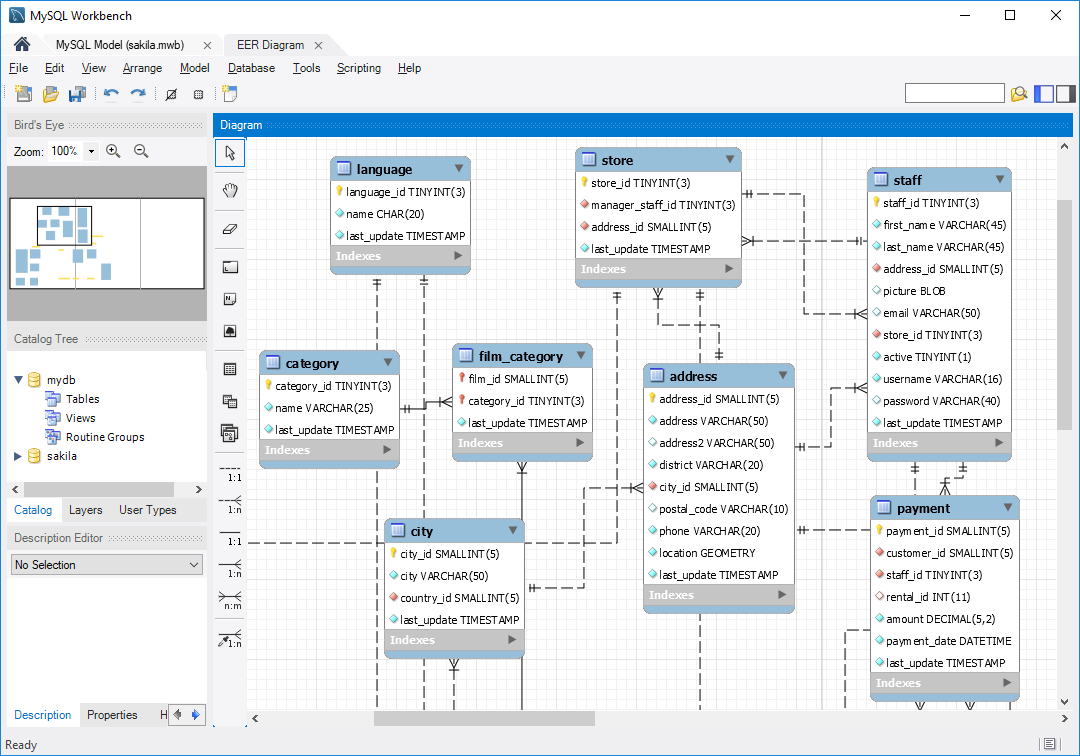

In [3]:
IMG_PATH = '/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-3.png'
IMG_BASENAME = os.path.basename(IMG_PATH)
tablas, cardinalidades = get_tablas(IMG_BASENAME)
img = Image.open(IMG_PATH)
img

In [38]:
ocr = PaddleOCR(use_angle_cls=False, lang='en', show_log=False, 
                det_algorithm_dir="/home/nacho/TFI-Cazcarra/ocr/db/", 
                #rec_char_dict_path="../icr15_dict_original.txt",
                rec_algorithm_dir="/home/nacho/TFI-Cazcarra/ocr/svtr/", det_db_score_mode="slow")

In [39]:
import cv2

In [40]:
def reescale(img, scale_percent=150):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
    return img

In [41]:
img = Image.open(IMG_PATH)
img = np.array(img)

images = []
results = []

for t in tablas:
    tabla_cropped = img[t[1]:t[3], t[0]:t[2]]
    tabla_cropped = reescale(tabla_cropped)
    result = ocr.ocr(tabla_cropped, cls=False)
    
    images.append(Image.fromarray(tabla_cropped))
    results.append(result[0])

In [42]:
def get_allowed_dtypes(db_name):
    if db_name.lower() == "mysql":
        STRING_TYPES = ["CHAR", "VARCHAR", "BINARY", "VARBINARY", "TINYBLOB", "TINYTEXT", "TEXT", "BLOB", 
                        "MEDIUMTEXT", "MEDIUMBLOB", "LONGTEXT", "LONGBLOB", "ENUM", "SET"]
        NUMERIC_TYPES = ["BIT", "TINYINT", "BOOLEAN", "SMALLINT", "MEDIUMINT", "INT", "INTEGER", "BIGINT", 
                         "FLOAT", "DOUBLE", "DOUBLE PRECISION", "DECIMAL", "DEC"]
        DATETIME_TYPES = ["DATE", "DATETIME", "TIMESTAMP", "TIME", "YEAR"]
        SPATIAL_TYPES = ["GEOMETRY", "POINT", "LINESTRING", "POLYGON"]
        return (STRING_TYPES + NUMERIC_TYPES + DATETIME_TYPES + SPATIAL_TYPES)
    else:
        print(f"'{db_name}' not supported yet!")
        return []

In [43]:
def get_dtype_number(text):
    if "," not in text:
        return re.findall("\d+", text) # Devuelve solo numeros juntos.
    else:
        return re.findall("\d+\,\d+", text) # Devuelve numeros con coma para dtypes como DECIMAL(5,2)

In [44]:
def sep_text(text):
    return re.findall("[A-Z]+[^A-Z]*|[^A-Z]+",text)

In [45]:
def get_dtype(possible_dtype, dtypes):
    dict_dtypes = {k: jellyfish.jaro_distance(possible_dtype, k) for k in dtypes}
    return (max(dict_dtypes, key=dict_dtypes.get), max(dict_dtypes.values()))

In [46]:
# El problema es si se confunde una L por una |
def clean_attribute(attribute):
    return re.sub("[^0-9a-zA-Z$_]+", "", attribute)

In [47]:
def separate(text, db_name="mysql"):
    text_list = sep_text(text)
    flag = False
    attribute = ""
    i = 0
    while not flag:
        if text_list[i].islower():
            attribute += text_list[i]
            i += 1
        else:
            flag = True
    attribute = clean_attribute(attribute)
    dtype = "".join(text_list[i:])
    dtype_number = get_dtype_number(dtype)
    dtype = dtype.replace("(", "").replace(")","")
    dtype, _ = get_dtype(dtype, dtypes=get_allowed_dtypes(db_name))
    if dtype_number:
        dtype += f"({dtype_number[0]})"
        
    return attribute, dtype

In [48]:
def clean_texts(texts):
    if "Indexes" in texts:
        texts.remove("Indexes")
        
    table_name = texts[0]
    
    attributes = {} # K=name, V=type
    for t in texts[1:]:
        attribute, dtype = separate(t, db_name="mysql")
        attributes[attribute.strip()] = dtype
            
    return table_name, attributes





['language', '7language_id TINYINT(3)', 'name CHAR(20)', 'Iast_update TIMESTAMP', 'Indexes']
('language', {'7language_id': 'TINYINT(3)', 'name': 'CHAR(20)', '': 'MEDIUMTEXT'})


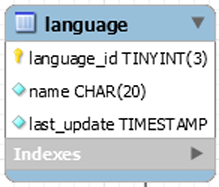





['store', 'store_id TINYINT(3)', 'm anager_staff_id TINYINT(3)', 'address_id SMALLINT(5)', 'last_update TIMEST AMP', 'Indexes', 'A']
('store', {'store_id': 'TINYINT(3)', 'manager_staff_id': 'TINYINT(3)', 'address_id': 'SMALLINT(5)', 'last_update': 'TIMESTAMP', '': 'DATE'})


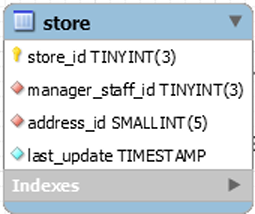





['staff', 'staff_id TINYINT(3)', 'first_nam e V ARCHAR(45)', 'last_name VARCHAR(45)', 'address_id SMALLINT(5)', 'picture BLOB', 'email VARCHAR(50)', 'store_id TINYINT(3)', 'active TINYINT(1)', 'username VARCHAR(16)', 'password VARCHAR(40', 'last_update TIMESTAMP', 'Indexes']
('staff', {'staff_id': 'TINYINT(3)', 'first_name': 'VARCHAR(45)', 'last_name': 'VARCHAR(45)', 'address_id': 'SMALLINT(5)', 'picture': 'BLOB', 'email': 'VARCHAR(50)', 'store_id': 'TINYINT(3)', 'active': 'TINYINT(1)', 'username': 'VARCHAR(16)', 'password': 'VARCHAR(40)', 'last_update': 'TIMESTAMP'})


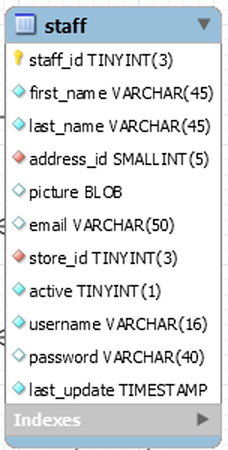





['payment', 'paym ent_id SMALLINT(5)', 'customer_id SMALLINT (5)', 'staff_id TINY INT(3)', 'rental_id INT(11)', 'amount DECIMAL(5,2)', 'paym ent_date DATETIME', 'last_update TIMESTAMP', 'Indexes', 'A']
('payment', {'payment_id': 'SMALLINT(5)', 'customer_id': 'SMALLINT(5)', 'staff_id': 'TINYINT(3)', 'rental_id': 'INT(11)', 'amount': 'DECIMAL(5,2)', 'payment_date': 'DATETIME', 'last_update': 'TIMESTAMP', '': 'DATE'})


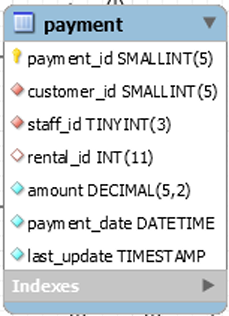





['category', 'category_id TINYINT(3)', 'name VARCHAR(25)', 'last_update TIMEST AMP', 'Indexes']
('category', {'category_id': 'TINYINT(3)', 'name': 'VARCHAR(25)', 'last_update': 'TIMESTAMP'})


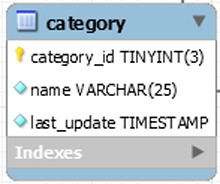





['film_category', 'film_id SMALLINT(5)', 'category_id TINYINT(3)', 'last_update TIMESTAMP', 'Indexes']
('film_category', {'film_id': 'SMALLINT(5)', 'category_id': 'TINYINT(3)', 'last_update': 'TIMESTAMP'})


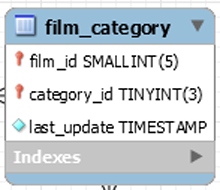





['city', '? city_id SMALLINT(5)', 'city VARCHAR(50)', 'country_id SMALLINT(5)', 'last_update TIMESTAMP', 'Indexes']
('city', {'city_id': 'SMALLINT(5)', 'city': 'VARCHAR(50)', 'country_id': 'SMALLINT(5)', 'last_update': 'TIMESTAMP'})


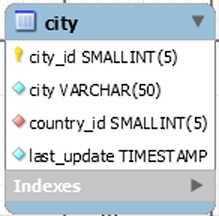





['address', 'address_id SMALLINT(5)', 'address V ARCHAR(50)', 'address2 VARCHAR(50)', 'district VARCHAR(20)', 'city_id SMALLINT(5)', 'postal_code VARCHAR(10)', 'phone VARCHAR(20)', 'location GEOMETRY', 'last_update TIMESTAMP', 'Indexes']
('address', {'address_id': 'SMALLINT(5)', 'address': 'VARCHAR(50)', 'address2': 'VARCHAR(50)', 'district': 'VARCHAR(20)', 'city_id': 'SMALLINT(5)', 'postal_code': 'VARCHAR(10)', 'phone': 'VARCHAR(20)', 'location': 'GEOMETRY', 'last_update': 'TIMESTAMP'})


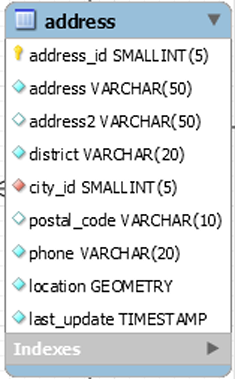

In [49]:
for i, r in zip(images, results):
    boxes = [line[0] for line in r]
    txts = [line[1][0].strip() for line in r]
    scores = [line[1][1] for line in r]
    print("\n\n\n")
    print(txts)
    table, dict_attributes = clean_texts(txts)
    
    print(table, dict_attributes)
    display(i)

In [110]:
def create_code(table, dict_attributes):
    '''
    Crea una tabla de MySQL
    '''
    attributes_code = "  "
    
    i = 0
    for k, v in dict_attributes.items():
        attributes_code += k + " " + v
        if i == 0:
            attributes_code += " PRIMARY KEY"
            
        if i != len(dict_attributes)-1:
            attributes_code += ",\n   "
        else:
            attributes_code += "   "
            
        i += 1
    
    llave_abre = "{"
    llave_cierra = "}"
    code = f" CREATE TABLE {table} ( \n {attributes_code} \n )"
    return code

In [111]:
# El create_code tiene que ser después del for de clean_texts, 
# asi puedo chequear que si existe {tabla}_id, es una FK.

for i, r in zip(images, results):
    txts = [line[1][0].strip() for line in r]
    table, dict_attributes = clean_texts(txts)
    print(create_code(table, dict_attributes))
    print("\n\n")

 CREATE TABLE language ( 
   7language_id TINYINT(3) PRIMARY KEY,
   name CHAR(20),
    MEDIUMTEXT    
 )



 CREATE TABLE store ( 
   store_id TINYINT(3) PRIMARY KEY,
   manager_staff_id TINYINT(3),
   address_id SMALLINT(5),
   last_update TIMESTAMP,
    DATE    
 )



 CREATE TABLE staff ( 
   staff_id TINYINT(3) PRIMARY KEY,
   first_name VARCHAR(45),
   last_name VARCHAR(45),
   address_id SMALLINT(5),
   picture BLOB,
   email VARCHAR(50),
   store_id TINYINT(3),
   active TINYINT(1),
   username VARCHAR(16),
   password VARCHAR(40),
   last_update TIMESTAMP    
 )



 CREATE TABLE payment ( 
   payment_id SMALLINT(5) PRIMARY KEY,
   customer_id SMALLINT(5),
   staff_id TINYINT(3),
   rental_id INT(11),
   amount DECIMAL(5,2),
   payment_date DATETIME,
   last_update TIMESTAMP,
    DATE    
 )



 CREATE TABLE category ( 
   category_id TINYINT(3) PRIMARY KEY,
   name VARCHAR(25),
   last_update TIMESTAMP    
 )



 CREATE TABLE film_category ( 
   film_id SMALLINT(5) PRIMARY KEY